In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Filling Null

In [3]:
from scipy.stats import mode
def fill_null(data,column,column_by):
    mode = data.pivot_table(values=column,
                                   columns=column_by,
                                   aggfunc=lambda x: x.mode().iat[0])
    miss_bool = data[column].isnull() 
    data.loc[miss_bool,column] = data.loc[miss_bool,column_by].apply(lambda x: mode[x])

    
fill_null(train,'education','department')
fill_null(test,'education','department')

train[['previous_year_rating']]=train[['previous_year_rating']].fillna(0.0)
test[['previous_year_rating']]=test[['previous_year_rating']].fillna(0.0)

# Feature Engineering

In [4]:
train.education.value_counts()

Bachelor's          39078
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

In [5]:
train.loc[train.education=="Below Secondary",'education']=1
train.loc[train.education=="Bachelor's",'education']=2
train.loc[train.education=="Master's & above",'education']=3

test.loc[test.education=="Below Secondary",'education']=1
test.loc[test.education=="Bachelor's",'education']=2
test.loc[test.education=="Master's & above",'education']=3

In [6]:
region_over_ten = []
region_not_over_ten = []
for i in range(1,35):
    region = 'region_' + str(i)
    percentage = sum(train[train.region==region].is_promoted==1)/len(train[train.region==region].is_promoted==1)*100
    if percentage>10:
        region_over_ten.append(region)
        print(region + ' : ' + str(percentage))
    else:
        region_not_over_ten.append(region)

train['region'] = train['region'].replace(region_over_ten,'region_over_ten')
train['region'] = train['region'].replace(region_not_over_ten,'region_not_over_ten')
test['region'] = test['region'].replace(region_over_ten,'region_over_ten')
test['region'] = test['region'].replace(region_not_over_ten,'region_not_over_ten')

region_3 : 10.69364161849711
region_4 : 14.44509688784498
region_7 : 10.654552963039439
region_17 : 13.693467336683419
region_22 : 11.418792781580585
region_23 : 11.659574468085106
region_25 : 12.576312576312576
region_28 : 11.684370257966616


In [7]:
train['trainings_per_year'] = train['no_of_trainings']/train['length_of_service']
test['trainings_per_year'] = test['no_of_trainings']/test['length_of_service']

In [8]:
train['joining_age'] = train['age']-train['length_of_service']
test['joining_age'] =test['age']-test['length_of_service']

In [9]:
train['age'] = pd.qcut(train.age, q=4, labels=False )
test['age'] = pd.qcut(test.age, q=4, labels=False )

In [10]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,trainings_per_year,joining_age
0,65438,Sales & Marketing,region_over_ten,3,f,sourcing,1,2,5.0,8,1,0,49,0,0.125000,27
1,65141,Operations,region_over_ten,2,m,other,1,1,5.0,4,0,0,60,0,0.250000,26
2,7513,Sales & Marketing,region_not_over_ten,2,m,sourcing,1,2,3.0,7,0,0,50,0,0.142857,27
3,2542,Sales & Marketing,region_over_ten,2,m,other,2,2,1.0,10,0,0,50,0,0.200000,29
4,48945,Technology,region_not_over_ten,2,m,other,1,3,3.0,2,0,0,73,0,0.500000,43


In [11]:
train['joining_age'] = pd.qcut(train.joining_age, q=4, labels=False )
test['joining_age'] = pd.qcut(test.joining_age, q=4, labels=False )

In [12]:
train['length_of_service'] = pd.qcut(train.length_of_service, q=4, labels=False )
test['length_of_service'] = pd.qcut(test.length_of_service, q=4, labels=False )

In [13]:
train['total_score'] = train['no_of_trainings']*train['avg_training_score']
test['total_score'] = test['no_of_trainings']*test['avg_training_score']

In [14]:
categorical_var = ['department','region','gender','recruitment_channel','age','joining_age','length_of_service']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in categorical_var:
    train[i] = le.fit_transform(train[i])
    test[i] = le.fit_transform(test[i])

In [15]:
train = pd.get_dummies(train, columns=categorical_var)
test = pd.get_dummies(test, columns=categorical_var)
for count in categorical_var:
     train=train.drop(count + '_0',axis=1)
     test=test.drop(count + '_0',axis=1)

# Model Training

In [16]:
y_train = train['is_promoted']
x_train = train.drop('is_promoted',axis=1)
x_train = x_train.drop('employee_id',axis=1)
x_test = test.drop('employee_id',axis=1)

In [17]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier(max_depth = 35)
DTC.fit(x_train,y_train)
y_pred = DTC.predict(x_test)

In [18]:
employee_id = test.employee_id.values
d = {'employee_id': employee_id, 'is_promoted': y_pred}
df = pd.DataFrame(data=d)
df.to_csv('output.csv', encoding='utf-8', index=False)

# Score

In [19]:
from sklearn.model_selection import train_test_split
train_x_1 , test_x_1, train_y_1, test_y_1 = train_test_split(x_train,y_train,test_size=0.33)

In [20]:
from sklearn.metrics import  confusion_matrix
def cm(model,train_x,train_y,test_x,test_y):
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    cm = confusion_matrix(test_y,y_pred)
    return cm

In [21]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=12)
model_acc = cm(dtc,train_x_1,train_y_1,test_x_1,test_y_1)
accuracy = (model_acc[0][0]+model_acc[1][1])/(model_acc[0][0]+model_acc[0][1]+model_acc[1][0]+model_acc[1][1])
accuracy

0.9378006302869464

# Model Selection

## Max Depth

In [22]:
from sklearn.metrics import roc_curve, auc

dt = DecisionTreeClassifier()
dt.fit(train_x_1, train_y_1)
y_pred = dt.predict(test_x_1)

false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y_1, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6975531993676211

In [23]:
train_results = []
test_results = []

depth = np.linspace(1, 32, 32, endpoint=True)
for i in depth:
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(train_x_1,train_y_1)
    train_pred = dt.predict(train_x_1)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y_1, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    test_pred = dt.predict(test_x_1)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y_1, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

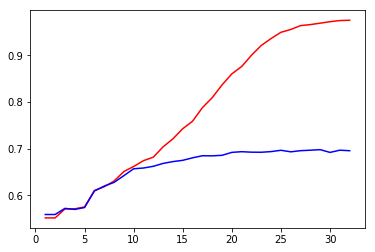

In [24]:
from matplotlib.legend_handler import HandlerLine2D
plt.plot(depth, train_results, color = 'red')
plt.plot(depth, test_results, color = 'blue')
plt.show()

## Min Sample split

In [25]:
min_samples_splits = np.linspace(0.01, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(train_x_1,train_y_1)
    train_pred = dt.predict(train_x_1)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y_1, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    test_pred = dt.predict(test_x_1)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y_1, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

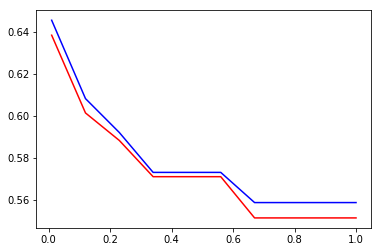

In [26]:
plt.plot(min_samples_splits, test_results, color = 'blue')
plt.plot(min_samples_splits, train_results, color = 'red')

## Min sample leaf

In [27]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(train_x_1,train_y_1)
    train_pred = dt.predict(train_x_1)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y_1, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    test_pred = dt.predict(test_x_1)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y_1, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

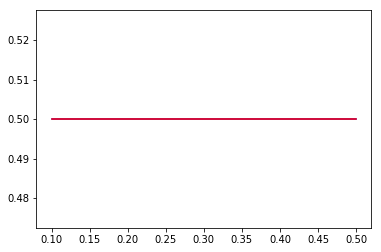

In [28]:
plt.plot(min_samples_leafs, test_results, color = 'blue')
plt.plot(min_samples_leafs, train_results, color = 'red')

## Max Features

In [29]:
max_features = list(range(1,train_x_1.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(max_features=max_feature)
    dt.fit(train_x_1,train_y_1)
    train_pred = dt.predict(train_x_1)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y_1, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    test_pred = dt.predict(test_x_1)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y_1, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

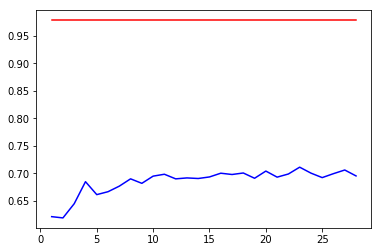

In [30]:
plt.plot(max_features, test_results, color = 'blue')
plt.plot(max_features, train_results, color = 'red')

In [31]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

plt.style.use("ggplot")

clf = DecisionTreeClassifier()

param_grid = {
    'max_depth' : [5, 20, 35],
    'max_features': [3, 5, 10, train_x_1.shape[1]],
    
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

def grid_search_wrapper(refit_score='precision_score'):
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(train_x_1, train_y_1)

    # make the predictions
    y_pred = grid_search.predict(test_x_1)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Decision Tree optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(test_y_1, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search
grid_search_clf = grid_search_wrapper(refit_score='precision_score')
results = pd.DataFrame(grid_search_clf.cv_results_)
#results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features']].round(3).head()

C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Best params for precision_score
{'max_depth': 5, 'max_features': 10}

Confusion matrix of Decision Tree optimized for precision_score on the test data:
     pred_neg  pred_pos
neg     16488        51
pos      1367       181


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features
0,0.809,0.093,0.921,5,3
1,0.781,0.092,0.920,5,5
2,0.832,0.145,0.925,5,10
3,0.831,0.148,0.925,5,29
4,0.429,0.295,0.907,20,3


- F1 score is the harmonic mean of precision and recall
- Learnt the importance of precision and recall values

# Cross validation score

In [32]:
from sklearn.model_selection import KFold # import KFold

In [33]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
DTC = DecisionTreeClassifier(max_depth = 35)

C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
scores = cross_val_score(DTC, x_train ,y_train, cv=6)
print('Cross-validated scores:', scores)

Cross-validated scores: [0.89917898 0.89917898 0.90574713 0.89742748 0.90442303 0.89763521]


In [35]:
scores = cross_val_score(DTC, x_train, y_train, scoring='f1', cv=10)

In [36]:
scores.mean()*100, scores.std()*100

(43.38053110880274, 1.6840564487259124)

# Light BGM model selection

In [40]:
import lightgbm as lgb
from sklearn.metrics import f1_score


def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

lgtrain = lgb.Dataset(train_x_1, label=train_y_1)
lgval = lgb.Dataset(test_x_1, label=test_y_1)
evals_result = {}
params = {
        "objective" : "binary",
       "n_estimators":10000,
       "reg_alpha" : 0.1,
       "reg_lambda":0.1,
       "n_jobs":-1,
       "colsample_bytree":.8,
       "min_child_weight":8,
       "subsample":0.8715623,
       "min_data_in_leaf":100,
       "nthread":4,
       "metric" : "f1",
       "num_leaves" : 600,
       "learning_rate" : 0.01,
       "verbosity" : -1,
       "seed": 120,
       "max_bin":60,
       'max_depth':15,
       'min_gain_to_split':.0222415,
       'scale_pos_weight':2
    }
model = lgb.train(params, lgtrain, 10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result,feval=lgb_f1_score)


C:\Users\muralish\Miniconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classific

Training until validation scores don't improve for 100 rounds.


C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classificatio

C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classificatio

C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classificatio

[100]	training's f1: 0.338356	valid_1's f1: 0.35443
[200]	training's f1: 0.467446	valid_1's f1: 0.468735
[300]	training's f1: 0.526714	valid_1's f1: 0.5031
[400]	training's f1: 0.564496	valid_1's f1: 0.513847
[500]	training's f1: 0.580309	valid_1's f1: 0.51505
[600]	training's f1: 0.595018	valid_1's f1: 0.512629
Early stopping, best iteration is:
[527]	training's f1: 0.583437	valid_1's f1: 0.516264


In [41]:
import lightgbm as lgb
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

d_train = lgb.Dataset(x_train, label=y_train)
params = {
        "n_estimators" : 100,
    }
lgtrain = lgb.Dataset(train_x_1, label=train_y_1)
lgval = lgb.Dataset(test_x_1, label=test_y_1)
evals_result = {}
model = lgb.train(params, lgtrain, 10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result,feval=lgb_f1_score)

C:\Users\muralish\Miniconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 100 rounds.


C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\muralish\Miniconda3\lib\site-packages\sklearn\metrics\classificatio

[100]	training's f1: 0.514056	valid_1's f1: 0.507336
Did not meet early stopping. Best iteration is:
[100]	training's f1: 0.514056	valid_1's f1: 0.507336


In [42]:
pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)

In [43]:
pred_test_y[pred_test_y>0.5]=1
pred_test_y[pred_test_y<0.5]=0
pred_test_y

array([0., 0., 0., ..., 0., 0., 1.])

# Light BGM model

In [ ]:
import lightgbm as lgb
d_train = lgb.Dataset(x_train, label=y_train)
params = {
        "objective" : "binary",
       "n_estimators":1000,
       "reg_alpha" : 0.1,
       "reg_lambda":0.1,
       "n_jobs":-1,
       "colsample_bytree":.8,
       "min_child_weight":8,
       "subsample":0.8715623,
       "min_data_in_leaf":100,
       "nthread":4,
       "metric" : "f1",
       "num_leaves" : 1000,
       "learning_rate" : 0.01,
       "verbosity" : -1,
       "seed": 120,
       "max_bin":60,
       'max_depth':15,
       'min_gain_to_split':.0222415,
       'scale_pos_weight':2,
    }
model = lgb.train(params, d_train, 100)

C:\Users\muralish\Miniconda3\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
y_pred=model.predict(x_test)
y_pred[y_pred>=0.5]=round(1)
y_pred[y_pred<0.5]=round(0)

In [ ]:
employee_id = test.employee_id.values
d = {'employee_id': employee_id, 'is_promoted': y_pred}
df = pd.DataFrame(data=d)
df.to_csv('output.csv', encoding='utf-8', index=False)